In [1]:
import matplotlib.pyplot as plt
import matplotlib
%matplotlib inline
matplotlib.style.use('seaborn')

In [2]:
from animerec.data import get_data
users, anime = get_data()

In [3]:
from sklearn.model_selection import train_test_split
train, test = train_test_split(users, test_size = 0.2) #let's split up the dataset into a train and test set.

In [4]:
#initialize some local variables
nUsers = len(train.user_id.unique())
nAnime = len(train.anime_id.unique())

# we'll need some data structures in order to vectorize computations
from collections import defaultdict
users = train.user_id
items = train.anime_id

user_index = defaultdict(lambda: -1) # maps a user_id to the index in the bias term.
item_index = defaultdict(lambda: -1) # maps an anime_id to the index in the bias term.

counter = 0
for user in users:
  if user_index[user] == -1:
    user_index[user] = counter
    counter += 1 

counter = 0
for item in items:
  if item_index[item] == -1:
    item_index[item] = counter
    counter += 1 

In [5]:
import tensorflow as tf

In [6]:
y = tf.cast(tf.constant(train['rating'].as_matrix(), shape=[len(train),1]), tf.float32)

In [96]:
def objective(alpha, Bi, Bu, y, lam):
    #construct the full items and user matrix.
    Bi_full = tf.gather(Bi, list(map(lambda x: item_index[x], train.anime_id)))
    Bu_full = tf.gather(Bu, list(map(lambda x: user_index[x], train.user_id)))
    alpha_full = tf.tile(alpha, (len(train), 1))
    
    return tf.reduce_sum(abs(alpha_full+Bi_full+Bu_full-y)) + lam * (tf.reduce_sum(Bi**2) + tf.reduce_sum(Bu**2))

In [97]:
#initialize alpha, Bi, Bu
alpha = tf.Variable(tf.constant([6.9], shape=[1, 1]))
Bi = tf.Variable(tf.constant([0.0]*nAnime, shape=[nAnime, 1]))
Bu = tf.Variable(tf.constant([0.0]*nUsers, shape=[nUsers, 1]))

In [98]:
optimizer = tf.train.AdamOptimizer(0.01)

In [99]:
obj = objective(alpha, Bi, Bu, y, 1)

In [100]:
trainer = optimizer.minimize(obj)

In [108]:
sess = tf.Session()
sess.run(tf.global_variables_initializer())
l = []
for iteration in range(500):
    cvalues = sess.run([trainer, obj])
    print("objective = " + str(cvalues[1]))
    l.append(cvalues[1])
cAlpha, cBi, cBu, cLoss = sess.run([alpha, Bi, Bu, obj])
print("\nFinal train loss is ", cLoss)

objective = 4.05139e+06
objective = 3.83107e+06
objective = 3.71955e+06
objective = 3.6082e+06
objective = 3.49719e+06
objective = 3.38534e+06
objective = 3.27295e+06
objective = 3.16019e+06
objective = 3.04972e+06
objective = 2.9956e+06
objective = 2.97143e+06
objective = 2.95027e+06
objective = 2.92532e+06
objective = 2.89536e+06
objective = 2.86101e+06
objective = 2.82384e+06
objective = 2.78537e+06
objective = 2.74792e+06
objective = 2.71527e+06
objective = 2.68809e+06
objective = 2.66575e+06
objective = 2.64752e+06
objective = 2.63265e+06
objective = 2.62043e+06
objective = 2.61017e+06
objective = 2.60121e+06
objective = 2.59297e+06
objective = 2.58489e+06
objective = 2.57671e+06
objective = 2.56853e+06
objective = 2.56056e+06
objective = 2.5531e+06
objective = 2.54639e+06
objective = 2.54061e+06
objective = 2.53583e+06
objective = 2.53201e+06
objective = 2.52898e+06
objective = 2.5265e+06
objective = 2.5243e+06
objective = 2.52217e+06
objective = 2.51998e+06
objective = 2.51772e+

Let's plot the objective and see how it decreases.

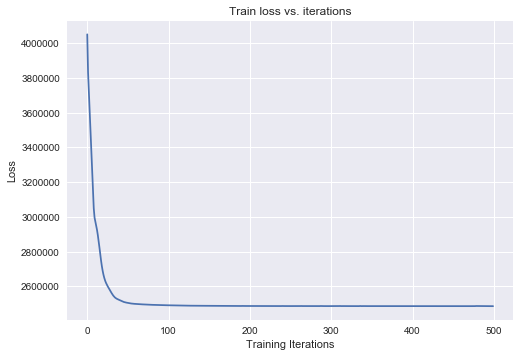

In [113]:
plt.plot(l)
plt.title('Train loss vs. iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Loss')

So by 100 iterations, the model has more or less converged.

Let's test the model on our test data now.

In [47]:
test_users = test['user_id']
test_anime = test['anime_id']
test_ratings = test['rating']

In [116]:
indices = test_users.map(lambda x: user_index[x])
bu = indices.map(lambda x: 0.0 if x == -1 else float(cBu[x]))
indices = test_anime.map(lambda x: item_index[x])
bi = indices.map(lambda x: 0.0 if x == -1 else float(cBi[x]))
preds = bu + bi + float(cAlpha)
MAE = 1.0/len(test) * sum(abs(test_ratings-preds))
print ('MAE on test set is: ', float(MAE))

MAE on test set is:  0.8954336155381862


So a simple linear model with no real user/item interaction gets us within 0.9 on average of a typical anime. That's pretty good as a baseline. In the next notebook, we'll be using a simple latent factor method and seeing how much that improves performance. Then, we'll consider using features in the latent factor method.